# Ensemble method

In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import sys
sys.path.append("../scripts")
from data_cleaning import clean_data

ModuleNotFoundError: No module named 'data_cleaning'

In [2]:
#train
train_raw = pd.read_csv("../data/train.csv")
train_clean = clean_data(train_raw)
train_clean.to_csv("../data/train_clean.csv", index=False)

#test
test_raw = pd.read_csv("../data/test.csv")
test_clean = clean_data(test_raw)
test_clean.to_csv("../data/test_clean.csv", index=False)

print("Saved train_clean.csv and test_clean.csv")

Saved train_clean.csv and test_clean.csv


In [2]:
df = pd.read_csv('../data/train_clean.csv')
# df = pd.read_csv('../data/train.csv')

# making label of rating_rejected feature into binary from continuous (0.0 to 1.0)
df["comment_text"] = df["comment_text"].fillna("").astype(str)
df["label"] = df["rating_rejected"]

In [ ]:
text_col = "comment_text"
df[text_col] = df[text_col].fillna("").astype(str)

y = df["label"]

cols = [
    c for c in df.columns
    if c not in [text_col, "label", "rating_rejected"]
]

In [4]:
train_idx, val_idx = train_test_split(
    df.index,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

y_train = df["label"].loc[train_idx]
y_val = df["label"].loc[val_idx]

In [5]:
X_train_both = df.loc[train_idx, ["comment_text"] + cols]
X_val_both   = df.loc[val_idx, ["comment_text"] + cols]

## Random Forest Base (both comment and numerics):

In [6]:
preprocess_rf = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(
            stop_words="english",
            ngram_range=(1, 2),
            min_df=5,
            max_features=5000
        ), text_col),
        ("num", "passthrough", cols),
    ]
)

In [11]:
rf_pipe = Pipeline([
    ("preprocess", preprocess_rf),
    ("rf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"
    ))
])

param_grid_rf = {
    "rf__n_estimators": [200],
    "rf__max_depth": [None, 30],
    "rf__min_samples_split": [2, 10],
    # "rf__min_samples_leaf": [1, 5],
}

grid_rf = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid_rf,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

# grid_rf.fit(X_train_both, y_train)

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=42)
small_idx, _ = next(sss.split(X_train_both, y_train))

X_train_small = X_train_both.iloc[small_idx]
y_train_small = y_train.iloc[small_idx]

grid_rf.fit(X_train_small, y_train_small)


print("Best params (RF):", grid_rf.best_params_)
print("Best CV F1 (RF):", grid_rf.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END rf__max_depth=None, rf__min_samples_split=10, rf__n_estimators=200; total time=21.1min
[CV] END rf__max_depth=30, rf__min_samples_split=2, rf__n_estimators=200; total time= 5.6min
[CV] END rf__max_depth=None, rf__min_samples_split=10, rf__n_estimators=200; total time=19.4min
[CV] END rf__max_depth=30, rf__min_samples_split=2, rf__n_estimators=200; total time= 3.6min
[CV] END rf__max_depth=30, rf__min_samples_split=2, rf__n_estimators=200; total time= 2.6min
[CV] END rf__max_depth=30, rf__min_samples_split=10, rf__n_estimators=200; total time= 3.0min
Best params (RF): {'rf__max_depth': 30, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best CV F1 (RF): 0.3461999774902175
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=200; total time=23.5min
[CV] END rf__max_depth=30, rf__min_samples_split=10, rf__n_estimators=200; total time= 2.4min
[CV] END rf__max_depth=30, rf__min_samples_split=10, rf__

In [12]:
best_rf = grid_rf.best_estimator_

y_val_pred_rf = best_rf.predict(X_val_both)

print("Validation accuracy (RF tuned):", accuracy_score(y_val, y_val_pred_rf))
print("\nValidation classification report (RF tuned):\n")
print(classification_report(y_val, y_val_pred_rf, digits=4))

Validation accuracy (RF tuned): 0.8581592111622302

Validation classification report (RF tuned):

              precision    recall  f1-score   support

           0     0.9658    0.8794    0.9205    297694
           1     0.2453    0.5570    0.3406     20952

    accuracy                         0.8582    318646
   macro avg     0.6055    0.7182    0.6305    318646
weighted avg     0.9184    0.8582    0.8824    318646



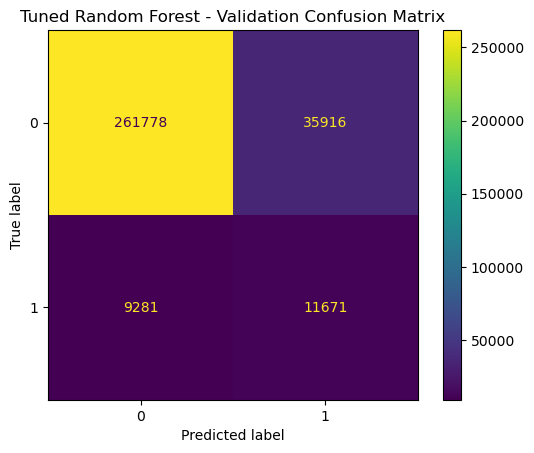

In [13]:
# confusion matrix for best RF ensemble model:
cm = confusion_matrix(y_val, y_val_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Tuned Random Forest - Validation Confusion Matrix")
plt.show()

Similarly to the SVM model's set up, we used TfidfVectorizer to vectorize the `comment_text` and the numeric features of the dataset. GridSearchCV was used to find the best set of hyperparameters of {'rf__max_depth': 30, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}. This model was RandomForestClassifier from sklearn. 

This did end up being the best model in terms of accuracy for toxicity, although there was a lower overall accuracy score. This is the best model, and it uses `comment_text` and numerics as features.